In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
from glob import glob
from os.path import join
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

####################### CONFIG ###########################################
restore_from = None
epoch = 100      # number of epochs
num_gpu = 1      # number of GPUs to train on
imgs_per_gpu = 24# batch size / num_gpu
num_classes = 2  # number of classes (including bg)
lr_start = 0.001 # starting learning rate
lr_decay = 0.0005# learning rate decay 
input_shape = (256, 256, 3)  # input dimensions
resize = True    # apply initial resizing to input_shape [True/False]
anchor_scales = (8, 16, 32, 64, 128)
rois_per_img = 120
# optimizer
# mask_loss
# bbox_loss
# class_loss
# rpn_loss
##########################################################################
# training data locations (list) or csv file path
trdata_dir = ['./data/samaww_60k/train/buildings/']
# labels locations (same order as above expected & same names) 
trdata_labels_dir = ['./data/samaww_60k/train/masks/']
valdata_dir = 
models = './models'

In [4]:
TRAIN_SIZE = glob()
VAL_SIZE = len()
TRAIN_DIR = '/home/ubuntu/mrcnn_data/delivery_1/train/'
VAL_DIR = '/home/ubuntu/mrcnn_data/delivery_1/validation/'

## Configurations

In [5]:
class BuildingsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "delivery_1_rot"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 15 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + buildings

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 120

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    
config = BuildingsConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           delivery_1_rot
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING   

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Load dataset using extension of the utils.Dataset class

In [7]:
class BuildingDataset(utils.Dataset):
    """Generates the buildings dataset
    """

    def load_buildings(self, count, data_dir, side_dim=256):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        data_dir: location of data. should have two subdirectories
            'buildings' (with images) and 'masks' (with masks)
        side_dim: the size of the generated images.
        """
        # Add classes
        self.add_class("buildings", 1, "building")
        
        # Add images
        img_paths = [join(data_dir, 'buildings', i) for i in os.listdir(join(data_dir, 'buildings'))]
        for ix, path in enumerate(img_paths):
            self.add_image("buildings", image_id=ix, path=path,
                           width=side_dim, height=side_dim, bg_color= np.array([0,0,0]))
            
    def load_mask(self, image_id):
        """Generate a mask for the corresponding image id.
        Masks are stored as 3d arrays in a directory called 'masks'
            with each instance encoded as a unique shade of gray.
        image_id: image id assigned in load_buildings
        returns array [h, w, instances]
        """
        image_info = self.image_info[image_id]
        mask = cv2.imread(re.sub("buildings/", "masks/", 
                                 image_info["path"]))
        instances = sorted(np.unique(mask))[1:]
        
        # Reformat mask
        new_mask = np.zeros([image_info['height'], 
                             image_info['width'], 
                             len(instances)])
        
        for ix, inst in enumerate(instances):
            new_mask[:,:,ix][mask[:,:,0] == inst] = 1
            
        # All class names will be one
        return new_mask, np.ones(len(instances)).astype(np.int32)
    
    def image_reference(self, image_id):
        """Give +vivid image name for a given image id for debugging
        """
        return self.image_info[image_id]["path"].split('/')[-1]
        

In [8]:
# Training dataset
dataset_train = BuildingDataset()
dataset_train.load_buildings(TRAIN_SIZE, TRAIN_DIR)
dataset_train.prepare()

# Validation dataset
dataset_val = BuildingDataset()
dataset_val.load_buildings(VAL_SIZE, VAL_DIR)
dataset_val.prepare()

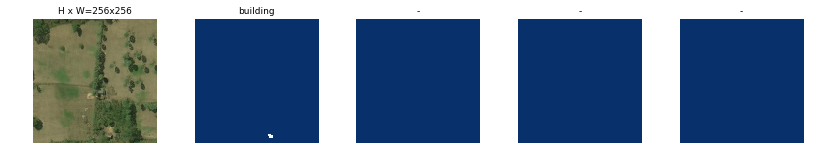

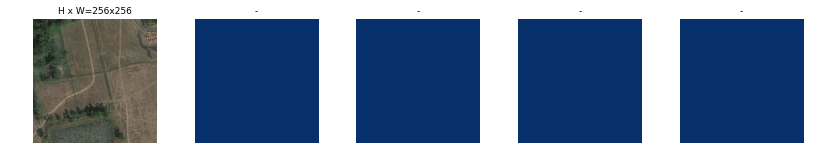

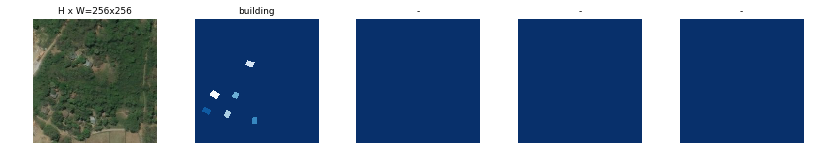

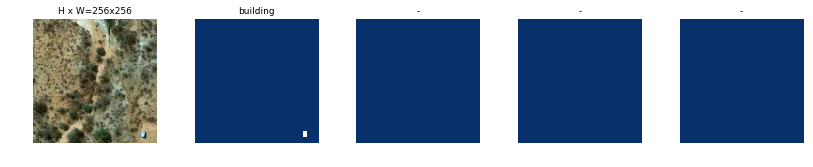

In [9]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [11]:
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/Mask_RCNN/models/122917_ptcoco/delivery_1_rot20180104T1834/mask_rcnn_delivery_1_rot_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/ubuntu/envs/mrcnn/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/envs/mrcnn/lib/python3.5/site-packages/keras/engine/training.py:2022: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
class InferenceConfig(BuildingsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
dataset_val.image_info

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
dataset_train.class_names

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())